In [3]:
import matplotlib.pyplot as plt
import psycopg2
import seaborn as sns
import pandas as pd
%load_ext sql
%sql postgresql://postgres@localhost:5432/northwind

In [5]:
%%sql

-- LOOK AT THE DB TABLES

SELECT table_name AS name,
       table_type AS type
  FROM information_schema.tables
 WHERE table_schema = 'public' AND table_type IN ('BASE TABLE', 'VIEW');


 * postgresql://postgres@localhost:5432/northwind
14 rows affected.


name,type
territories,BASE TABLE
order_details,BASE TABLE
employee_territories,BASE TABLE
us_states,BASE TABLE
customers,BASE TABLE
orders,BASE TABLE
employees,BASE TABLE
shippers,BASE TABLE
products,BASE TABLE
categories,BASE TABLE


In [3]:
%%sql

-- LIST EMPLOYEE NAMES AGAINST ORDERS

SELECT 
    e.first_name || ' ' || e.last_name as employee_name,
    o.order_id,
    o.order_date
from    orders as o
join    employees as e
on      o.employee_id = e.employee_id
limit   20;

 * postgresql://postgres@localhost:5432/northwind
20 rows affected.


employee_name,order_id,order_date
Steven Buchanan,10248,1996-07-04
Michael Suyama,10249,1996-07-05
Margaret Peacock,10250,1996-07-08
Janet Leverling,10251,1996-07-08
Margaret Peacock,10252,1996-07-09
Janet Leverling,10253,1996-07-10
Steven Buchanan,10254,1996-07-11
Anne Dodsworth,10255,1996-07-12
Janet Leverling,10256,1996-07-15
Margaret Peacock,10257,1996-07-16


In [3]:
%%sql

-- GET AN OVERVIEW OF INDIVIDUAL TABLES

SELECT *
FROM order_details
LIMIT 15;



 * postgresql://postgres@localhost:5432/northwind
15 rows affected.


order_id,product_id,unit_price,quantity,discount
10248,11,14.0,12,0.0
10248,42,9.8,10,0.0
10248,72,34.8,5,0.0
10249,14,18.6,9,0.0
10249,51,42.4,40,0.0
10250,41,7.7,10,0.0
10250,51,42.4,35,0.15
10250,65,16.8,15,0.15
10251,22,16.8,6,0.05
10251,57,15.6,15,0.05


In [7]:
%%sql

-- RANKING EMPLOYEE SALES PERFORMANCE

WITH        employee_totals AS ( 
    SELECT      o.employee_id, e.first_name, e.last_name,
                ROUND(SUM(od.unit_price * od.quantity * (1 - od.discount))::DECIMAL, 2) AS total_sales_revenue
    FROM        orders o
    JOIN        order_details od
    ON          o.order_id = od.order_id
    JOIN        employees e
    ON          o.employee_id = e.employee_id
    GROUP       BY o.employee_id, e.first_name, e.last_name
    )
SELECT      *,
RANK()      OVER(ORDER BY total_sales_revenue DESC)
FROM        employee_totals;

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,first_name,last_name,total_sales_revenue,rank
4,Margaret,Peacock,232890.85,1
3,Janet,Leverling,202812.84,2
1,Nancy,Davolio,192107.60,3
2,Andrew,Fuller,166537.76,4
8,Laura,Callahan,126862.28,5
7,Robert,King,124568.23,6
9,Anne,Dodsworth,77308.07,7
6,Michael,Suyama,73913.13,8
5,Steven,Buchanan,68792.28,9


In [8]:
%%sql

-- RUNNING TOTAL OF MONTHLY SALES

WITH    monthly_sales_table AS(

    SELECT  ROUND(SUM(od.unit_price * od.quantity * (1 - od.discount))::DECIMAL, 2) AS month_total_sales, 
            DATE_TRUNC('month', o.order_Date)::DATE AS month
    FROM    orders o    
    JOIN    order_details od
    ON      o.order_id = od.order_id
    GROUP   BY DATE_TRUNC('month', o.order_Date)
    ORDER   BY DATE_TRUNC('month', o.order_Date)
    )
SELECT  *, 
        SUM(month_total_sales) OVER(ORDER BY month 
                                    ROWS UNBOUNDED PRECEDING) AS running_total
FROM    monthly_sales_table;


 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


month_total_sales,month,running_total
27861.90,1996-07-01,27861.90
25485.28,1996-08-01,53347.18
26381.40,1996-09-01,79728.58
37515.72,1996-10-01,117244.30
45600.05,1996-11-01,162844.35
45239.63,1996-12-01,208083.98
61258.07,1997-01-01,269342.05
38483.63,1997-02-01,307825.68
38547.22,1997-03-01,346372.90
53032.95,1997-04-01,399405.85


In [16]:
%%sql

-- MONTH ON MONTH SALES GROWTH

WITH    monthly_sales_table AS(
    SELECT  SUM(od.unit_price * od.quantity * (1 - od.discount)) AS month_total_sales, 
            DATE_TRUNC('month', o.order_Date)::DATE AS month
    FROM    orders o    
    JOIN    order_details od
    ON      o.order_id = od.order_id
    GROUP   BY DATE_TRUNC('month', o.order_Date)
    ORDER   BY DATE_TRUNC('month', o.order_Date)
        ),

        lagged_sales_table AS(
    SELECT  month, month_total_sales, LAG(month_total_sales) OVER(ORDER BY month) AS previous_month_sales
    FROM    monthly_sales_table
        )
SELECT  month, ROUND(((month_total_sales - previous_month_sales) / previous_month_sales)::DECIMAL * 100, 2) AS sales_growth_rate
FROM    lagged_sales_table; 

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


month,sales_growth_rate
1996-07-01,None
1996-08-01,-8.53
1996-09-01,3.52
1996-10-01,42.21
1996-11-01,21.55
1996-12-01,-0.79
1997-01-01,35.41
1997-02-01,-37.18
1997-03-01,0.17
1997-04-01,37.58


In [17]:
%%sql

-- IDENTIFYING HIGH VALUE CUSTOMERS

WITH order_value_table AS(
SELECT      customer_id, o.order_id,
                ROUND(SUM(od.unit_price * od.quantity * (1 - od.discount))::DECIMAL, 2) AS order_sales_value
    FROM        orders o
    JOIN        order_details od
    ON          o.order_id = od.order_id
    GROUP       BY customer_id, o.order_id
)
SELECT  *, 
        CASE
        WHEN order_sales_value > AVG(order_sales_value) OVER () THEN 'Above average'
        ELSE 'Average/Below average'   
        END  AS customer_value
FROM    order_value_table
LIMIT   20;
   

 * postgresql://postgres@localhost:5432/northwind
20 rows affected.


customer_id,order_id,order_sales_value,customer_value
VINET,10248,440.00,Average/Below average
TOMSP,10249,1863.40,Above average
HANAR,10250,1552.60,Above average
VICTE,10251,654.06,Average/Below average
SUPRD,10252,3597.90,Above average
HANAR,10253,1444.80,Average/Below average
CHOPS,10254,556.62,Average/Below average
RICSU,10255,2490.50,Above average
WELLI,10256,517.80,Average/Below average
HILAA,10257,1119.90,Average/Below average


In [82]:
%%sql

-- COUNT HOW MANY ORDERS ARE ABOVE AVERAGE FOR EACH CUSTOMER

WITH order_value_table AS(
    SELECT      customer_id, o.order_id,
                SUM(od.unit_price * od.quantity * (1 - od.discount)) AS order_sales_value
    FROM        orders o
    JOIN        order_details od
    ON          o.order_id = od.order_id
    GROUP       BY customer_id, o.order_id
),
average_sale_value AS(
    SELECT      AVG(order_sales_value) AS ave_order_sales_value
    FROM        order_value_table
)
SELECT  customer_id, 
        SUM(CASE
        WHEN order_sales_value > (SELECT ave_order_sales_value
                                  FROM average_sale_value) THEN 1
                                  ELSE 0
                                  END) AS above_average_orders
FROM    order_value_table
GROUP   BY customer_id 
ORDER   BY above_average_orders DESC
LIMIT   20;

 * postgresql://postgres@localhost:5432/northwind
20 rows affected.


customer_id,above_average_orders
ERNSH,26
SAVEA,26
QUICK,22
HUNGO,11
RATTC,10
FOLKO,8
BONAP,8
FRANK,7
RICSU,7
HILAA,7


In [99]:
%%sql

-- PERCENTAGE SALES BY PRODUCT CATEGORY

WITH category_totals AS(
    SELECT      p.category_id, c.category_name,
                SUM(od.unit_price * od.quantity * (1 - od.discount)) AS "total_category_revenue"
    FROM        order_details od
    JOIN        products p
    ON          p.product_id = od.product_id
    JOIN        categories c
    ON          p.category_id = c.category_id
    GROUP       BY p.category_id, c.category_name
    )
SELECT  category_id, category_name, total_category_revenue,
        ROUND((total_category_revenue / SUM(total_category_revenue) OVER() *100)::DECIMAL, 2) AS category_percentage
FROM    category_totals
ORDER   BY category_percentage DESC;

 * postgresql://postgres@localhost:5432/northwind
8 rows affected.


category_id,category_name,total_category_revenue,category_percentage
1,Beverages,267868.17978624784,21.16
4,Dairy Products,234507.2845305777,18.53
3,Confections,167357.22547338586,13.22
6,Meat/Poultry,163022.3602687388,12.88
8,Seafood,131261.7365558489,10.37
2,Condiments,106047.08460955074,8.38
7,Produce,99984.58007357619,7.90
5,Grains/Cereals,95744.58735543818,7.56


In [24]:
%%sql

-- TOP PRODUCTS BY CATEGORY

WITH    product_revenue_table AS(
    SELECT      p.product_id, p.product_name, p.category_id, c.category_name,
                ROUND(SUM(od.unit_price * od.quantity * (1 - od.discount))::DECIMAL, 2) AS "total_product_revenue"
    FROM        order_details od
    JOIN        products p
    ON          p.product_id = od.product_id
    JOIN        categories c
    ON          p.category_id = c.category_id
    GROUP       BY p.category_id, p.product_id, c.category_name
    )
SELECT *
FROM(

        SELECT  *,
                ROW_NUMBER() OVER(PARTITION BY category_id 
                     ORDER BY total_product_revenue DESC) as row_number
        FROM product_revenue_table
    )   AS foo
WHERE   row_number < 4
LIMIT   20;

 * postgresql://postgres@localhost:5432/northwind
20 rows affected.


product_id,product_name,category_id,category_name,total_product_revenue,row_number
38,Côte de Blaye,1,Beverages,141396.74,1
43,Ipoh Coffee,1,Beverages,23526.70,2
2,Chang,1,Beverages,16355.96,3
63,Vegie-spread,2,Condiments,16701.10,1
61,Sirop d'érable,2,Condiments,14352.60,2
65,Louisiana Fiery Hot Pepper Sauce,2,Condiments,13869.89,3
62,Tarte au sucre,3,Confections,47234.97,1
20,Sir Rodney's Marmalade,3,Confections,22563.36,2
26,Gumbär Gummibärchen,3,Confections,19849.14,3
59,Raclette Courdavault,4,Dairy Products,71155.70,1


In [23]:
%%sql

--MONTHLY SALES GROWTH

WITH    monthly_sales_table AS(
    SELECT  SUM(od.unit_price * od.quantity * (1 - od.discount)) AS month_total_sales, 
            DATE_TRUNC('month', o.order_Date)::DATE AS month
    FROM    orders o    
    JOIN    order_details od
    ON      o.order_id = od.order_id
    GROUP   BY DATE_TRUNC('month', o.order_Date)
    ORDER   BY DATE_TRUNC('month', o.order_Date)
        ),

        lagged_sales_table AS(
    SELECT  month, month_total_sales, LAG(month_total_sales) OVER(ORDER BY month) AS previous_month_sales
    FROM    monthly_sales_table
        )
SELECT  month, ROUND(((month_total_sales - previous_month_sales) / previous_month_sales)::DECIMAL * 100, 2) AS sales_growth_rate
FROM    lagged_sales_table
LIMIT   20; 

 * postgresql://postgres@localhost:5432/northwind
20 rows affected.


month,sales_growth_rate
1996-07-01,None
1996-08-01,-8.53
1996-09-01,3.52
1996-10-01,42.21
1996-11-01,21.55
1996-12-01,-0.79
1997-01-01,35.41
1997-02-01,-37.18
1997-03-01,0.17
1997-04-01,37.58


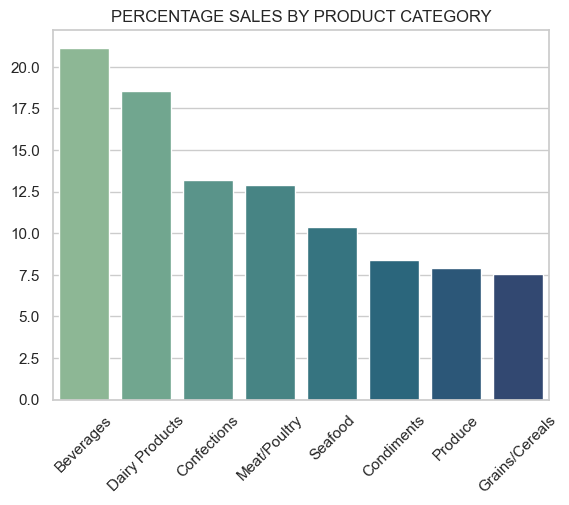

In [25]:
#GRAPHING PERCENTAGE SALES BY PRODUCT CATEGORY

#Connect to the db and run the query
conn = psycopg2.connect(host="localhost", database="northwind", user="postgres", password="")
cur = conn.cursor()
cur.execute("""WITH category_totals AS(
    SELECT      p.category_id, c.category_name,
                SUM(od.unit_price * od.quantity * (1 - od.discount)) AS "total_category_revenue"
    FROM        order_details od
    JOIN        products p
    ON          p.product_id = od.product_id
    JOIN        categories c
    ON          p.category_id = c.category_id
    GROUP       BY p.category_id, c.category_name
    )
SELECT  category_id, category_name, total_category_revenue,
        ROUND((total_category_revenue / SUM(total_category_revenue) OVER() *100)::DECIMAL, 2) AS category_percentage
FROM    category_totals
ORDER   BY category_percentage DESC;""")
results = cur.fetchall()

#Extract the data 
categories = [row[1] for row in results]
percentages = [row[3] for row in results]

#Create the bar chart

sns.set(style="whitegrid")
sns.barplot(x=categories, y=percentages, palette='crest')
plt.xticks(rotation=45)
plt.title("PERCENTAGE SALES BY PRODUCT CATEGORY")
plt.show()

/var/folders/m9/k369lbcn17d83pz89nrk3bz40000gp/T/ipykernel_10927/872301494.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query("""


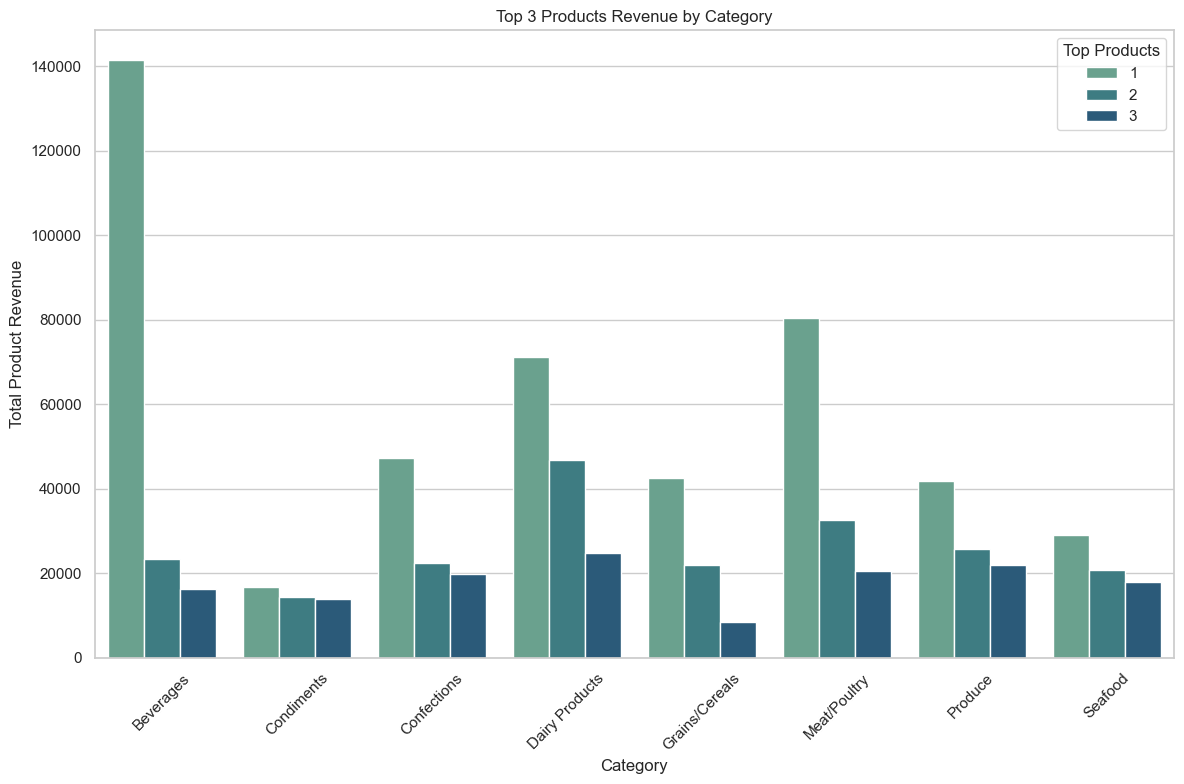

In [5]:
#GRAPHING THE TOP PRODUCTS BY PRODUCT CATEGORY

#Run the SQL query and store results in a dataframe

conn = psycopg2.connect(host="localhost", database="northwind", user="postgres", password="")
df = pd.read_sql_query("""
    WITH    product_revenue_table AS(
    SELECT      p.product_id, p.product_name, p.category_id, c.category_name,
                SUM(od.unit_price * od.quantity * (1 - od.discount)) AS "total_product_revenue"
    FROM        order_details od
    JOIN        products p
    ON          p.product_id = od.product_id
    JOIN        categories c
    ON          p.category_id = c.category_id
    GROUP       BY p.category_id, p.product_id, c.category_name
    )
SELECT *
FROM(

        SELECT  *,
                ROW_NUMBER() OVER(PARTITION BY category_id 
                     ORDER BY total_product_revenue DESC) as row_number
        FROM product_revenue_table
    )   AS foo
WHERE row_number < 4""", conn)

#Plot the chart using Seaborn

sns.set(style="whitegrid")
plt.figure(figsize=(12, 8))
sns.barplot(x="category_name", y="total_product_revenue", hue="row_number", palette="crest", data=df)
plt.title("Top 3 Products Revenue by Category")
plt.xlabel("Category")
plt.ylabel("Total Product Revenue")
plt.xticks(rotation=45)
plt.legend(title="Top Products", loc="upper right")
plt.tight_layout()
plt.show()